### What is Image Captioning?
As the name implies, image captioning is the task of taking/inputting an image to an AI model, and receiving a text caption describing/summarizing the contents of the image as its output. 

Image captioning models consist of 2 main components: a CNN (Convolutional Neural Network) encoder and a Language Model/RNN (some sort of NLP model that can produce text) decoder. The CNN encoder stores the important information about the inputted image, and the decoder will use that information to produce a text caption.

To train image captioning models, the most commonly used datasets are the `Flickr8k` dataset and the `MSCOCO` dataset.

The `Flickr8k` dataset consists of `8000` images — each with 5 different captions that can describe the image — and the `MSCOCO` dataset consists of `328000` images



####Encoder-Decoder Model Architecture
An Encoder-Decoder architecture consists of 2 components: a Convolutional Neural Network to encode the image (i.e. transform it into a rich embedding representation), and a Recurrent Neural Network (or an LSTM) that will take in as input this image, and be trained to sequentially decode the caption using a mechanism called Teacher Forcing. A good diagram of what this model looks like is below:
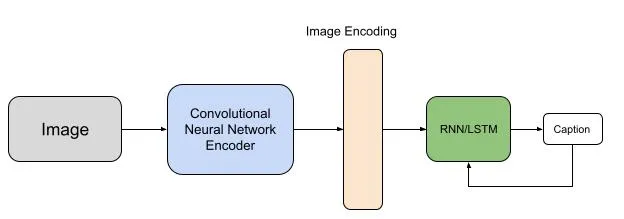

**The CNN**: Typically, the CNN tends to be the least computationally intensive/complex part of this model architecture. Why? Because most image captioning models tend to use transfer learning to simply load pre-trained weights of already existing powerful CNN architectures. 

**The RNN Decoder**: Unlike CNN’s, we typically do not use transfer learning in RNN’s/LSTM’s. With the LSTM architecture, the training is done sequentially, with each consecutive cell being trained before the next cell. The inputs to the LSTM are usually just the hidden state from the previous cell, and the output of the previous LSTM cell. However, for Generating Captions, we have to concatenate the feature embedding produced by the CNN with the previous output of the LSTM, and pass this concatenated tensor into the LSTM. And you can see this represented in the image of the whole encoder-decoder architecture:

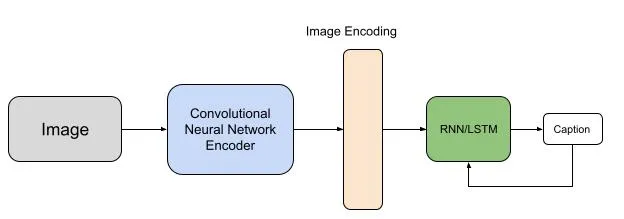



Some of the hyperparameters like hidden_size and embed_size parameters are to be chossen by the user. The vocab size is a parameter you will have to calculate based on what dataset you used. 

#### Modifications to the Encoder-Decoder Model
While the model architecture described above is already a good way to construct image captioning models, there are a couple of ways to modify the model to make it more powerful.

**Attention Mechanism**: At a high level, as the Decoder generates each word of the caption, an attention mechanism allows a model to pay attention to — or essentially focus on — relevant parts of the image. 

**Using a Transformer as a Decoder**: Using a powerful transformer like BERT is the next step towards building a better image captioner model. But while it may seem like an obvious choice, it is more challenging in reality. This is because the inherent architecture of the Transformer limits its input to words and text only. 


####ClipCap: CLIP Prefix for Image Captioning
ClipCap use the CLIP model, which was already trained over an extremely large number of images, thus is capable of generating semantic encodings for arbitrary images without additional supervision. To produce meaningful sentences authors have fine-tuned a pretrained language model, which has been proven to be successful for other natural language tasks. The key idea is to use the CLIP encoding as a prefix to the textual captions by employing a simple mapping network over the raw encoding, and then fine-tune our language model to generate a valid caption. In addition, we present another variant, where we utilize a transformer architecture for the mapping network and avoid the fine-tuning of GPT-2.

Authors use CLIP encoding as a prefix to the caption, by employing a simple mapping network, and then fine-tunes a language model to generate the image captions. The recently proposed CLIP model contains rich semantic features which were trained with textual context, making it best for vision-language perception.

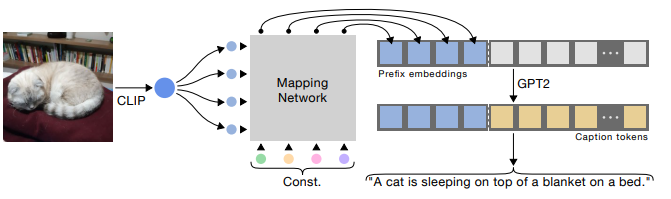

In [1]:
#@title Install
!pip install --upgrade --no-cache-dir gdown
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git
!pip install streamlit
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-x7yv4ydk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-x7yv4ydk
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (set

In [7]:
#@title Complete body of the app and helper functions for Generating Captions using Clip Prefix Image Captioning model
%%writefile app.py
# ************* Imports *******************
import streamlit as st
import yaml
import numpy as np
import base64
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from itertools import cycle
import cv2
import os
import numpy as np
import tempfile
import torch
import requests
from io import BytesIO
import clip
import os
import gdown
from zipfile import ZipFile
from torch import nn
import numpy as np
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from google.colab import files
import skimage.io as io
 
st.set_page_config(page_title="CaptionBot using ClipCap", page_icon="🖼️")


# ****************************** This Part contains Caption Model ******************************

# ******************************Download Model Weights from google drive link*******************

@st.cache_resource(show_spinner = False)
def download_weights(pretrained_model):   
  
  path_coco="./pretrained_models/wieghts_COCO.pt"
  path_concpt_cp="./pretrained_models/wieghts_Conceptual_captions.pt"

  current_directory = os.getcwd()
  save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
  os.makedirs(save_path, exist_ok=True)
   
  if pretrained_model == 'Conceptual Captions':
    if not os.path.exists(path_concpt_cp):
      model_path_Conceptual_captions = os.path.join(save_path, 'wieghts_Conceptual_captions.pt')
      with st.spinner("Downloading model... this may take awhile! \n Don't stop it!"):    
        gdown.download(id="1B381st8NdXEwCYKjgcBK6-0oLWv-Dmk2",output=model_path_Conceptual_captions)
    else:
      st.write("Weights are ready")

  elif pretrained_model == 'COCO':
    if not os.path.exists(path_concpt_cp):
      model_path_COCO = os.path.join(save_path, 'wieghts_COCO.pt')     
      with st.spinner("Downloading model... this may take awhile! \n Don't stop it!"): 
        gdown.download(id="1RCJI3OIrGWTsxJBnyJ7HsB4a5bifqrD4",output=model_path_COCO)
        
  else:
    st.write("Weights are ready")    


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    """
          function to check if GPU is available or not
    """  
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')

# ********Get the device as CPU/GPU****************
CUDA = get_device

# *******************Define the Model**************
class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

# **********************CLIP Model + GPT2 Tokenizer*******************
@st.cache_resource(show_spinner = False) # Caching so that model does not run everytime
def load_clip_model():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
  tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
  return clip_model,preprocess,tokenizer

with st.spinner("Firing Up your CaptionBot"):
  clip_model,preprocess,tokenizer =load_clip_model()

# *****************Load the model************************************
def load_model(pretrained_model):
  prefix_length = 10
  model = ClipCaptionModel(prefix_length)
  if  pretrained_model == 'COCO':
    model.load_state_dict(torch.load("/pretrained_models/wieghts_COCO.pt", map_location=CPU)) 
  else:
    model.load_state_dict(torch.load("/pretrained_models/wieghts_Conceptual_captions.pt", map_location=CPU))


  model = model.eval() # using model for inference only
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  return model

# ******************Caption Prediction Using Beam Search*************

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts
 
# *********************Caption Prediction without Beam Search*****************
def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

# *****************Inference**********************
def predict_captions(image,model,clip_model,preprocess,tokenizer,use_beam_search):
  prefix_length=10  
  pil_image=image
  device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #pil_img = Image(filename=UPLOADED_FILE)
  image = preprocess(pil_image).unsqueeze(0).to(device)
  with torch.no_grad():
      # if type(model) is ClipCaptionE2E:
      #     prefix_embed = model.forward_image(image)
      # else:
      prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
      prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)  
  if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
  else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
  return generated_text_prefix


# *****************use this because streamlit button does not save the state*******************                     
if "clicked" not in st.session_state:
  st.session_state.clicked = False

#**********************App Starts here********************************************************
def main():
    
    #st.title("Image Caption Prediction")
    st.header('Welcome to Image Caption Prediction!')
    st.write('This is a sample app that demonstrates the use ClipCap for Image Caption Generation .🚀')
    st.write('Visit the [Github](https://github.com/minakshimathpal/Image-Caption-App-using-Streamlit) repo for detailed exaplaination and to get started right away.')
    st.video("https://youtu.be/GMbCJon--6A")
    st.sidebar.title("EasyImageCaptioning")

    #***** Adding form to wrap starting components together****
    form1= st.sidebar.form(key="App Mode")
    app_mode= form1.selectbox("Choose the app mode",["","About Me","Sample Images","Upload Image","Upload URL"])
    pretrained_model= form1.selectbox("Choose a pretrained model",["","COCO","Conceptual Captions"])
    use_beam_search= form1.checkbox("use beam search to generate the output text")
    submitted1=form1.form_submit_button("Submit")
    if submitted1:
      if pretrained_model=="" or app_mode=="":
        st.sidebar.markdown(""" <style> .font {font-size:15px ; font-family: 'Cooper Black'; color: #FF9633;} 
                    </style> """, unsafe_allow_html=True)
        st.sidebar.markdown('<p class="font">Please check if pretrained model or app mode is valid </p>', unsafe_allow_html=True)
              
      else:
        download_weights(pretrained_model)


    @st.cache_data
    def image_resize(image, width= None , height= None, inter= cv2. INTER_AREA):
        dim= None
        (h,w)= image.shape[:2]

        if width is None and height is None:
            return image

        if width is None:
            r= width/float(w)
            dim = (int(w*r), height)

        else:
            r= width/float(w)
            dim= (width ,int(h*r))   

        # resize image
        resized= cv2.resize(image,dim,interpolation=inter)

        return resized 
    
    if app_mode=="About Me":
        
        st.markdown(  """
                 About Me \n
                Hey this is Minakshi Mathpal from Bangalore.I’m an interdisciplinary AI researcher & engineer, going where first-principles thinking takes me, with the ability to apply ML techniques
                and leverage algorithms to solve real-world business problems.Experienced in writing code to build sustainable machine learning models
                and neural networks using python. Certified with Diploma in Artificial Intelligence and Machine Learning from Great Lakes Executive
                Learning, approved by University of Austin, Texas

                Also check out my github and LinkedIn to see my work \n

                - [LinkedIn](https://www.linkedin.com/in/minakshi-mathpal-9b78b915b/)
                - [Github](https://github.com/minakshimathpal)
                - [ePortfolio](https://eportfolio.mygreatlearning.com/minakshi10)
        """
        )
    elif app_mode == "Sample Images":
        st.sidebar.markdown("---")

        filteredimages= {"Image1":"https://drive.google.com/file/d/1iNV8wCpR_a6ZOYrS4Wl31gKlIQ7STXY-/view?usp=share_link",
                     "Image2":"https://drive.google.com/file/d/1LqebnIYNxkbkHj_1_ZrCgBmHdkzmhr4h/view?usp=share_link",
                     "Image3":"https://drive.google.com/file/d/1slJz2SpYCAO9KOK8e-zQBFhOlEXJwjPC/view?usp=share_link",
                     "Image4":"https://drive.google.com/file/d/1noTV3S5XXjRCNdcIAXBUAgb_AD-H-rCc/view?usp=share_link"
                     }    
        form2= st.sidebar.form(key="Sample Image")
        sampleimage= form2.selectbox("Select an image",("","Image1","Image2","Image3","Image4"))
        
        submitted2=form2.form_submit_button("Submit")

        # **************************processing the selected image for displaying *******************       
        if submitted2 or st.session_state["clicked"] : 
            st.session_state["clicked"] = True                        
            if sampleimage =="" :
              st.sidebar.markdown(""" <style> .font {font-size:15px ; font-family: 'Cooper Black'; color: #FF9633;} 
                    </style> """, unsafe_allow_html=True)
              st.sidebar.markdown('<p class="font">Please provide a valid Image </p>', unsafe_allow_html=True)                 

            else:
              url = filteredimages[sampleimage]        
              path ='https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
              response = requests.get(path)
              img= np.array(Image.open(BytesIO(response.content)))
              #img = image_resize(img,width= 600 , height= 200, inter= cv2. INTER_AREA)
              col1= st.columns(1) 
              form4= col1[0].form("Image and Caption")
              col_form4= form4.columns(2)
              col_form4[0].write("Image")
              col_form4[0].image(img) 
              submitted=form4.form_submit_button("Get Captions")           
              
              if submitted:
                with st.spinner("Downloading model... this may take awhile! \n Don't stop it!"):
                  model = load_model(pretrained_model)
                  pil_image = Image.fromarray(img)
                  captions=predict_captions(pil_image,model,clip_model,preprocess,tokenizer,use_beam_search)
                  
                  col_form4[1].text_area(label="Captions",value=captions,height=100)  

              
                   

    elif app_mode == "Upload Image":
        st.sidebar.markdown("---")
        form3= st.sidebar.form(key="Upload an image")
        img_file_buffer= form3.file_uploader("Upload an image",type=["jpg","jpeg","png"]) 
        submitted3=form3.form_submit_button("Submit")  

        if submitted3 or st.session_state["clicked"] : 
            st.session_state["clicked"] = True  
        # **************************processing the uploaded image for displaying *******************   
            if img_file_buffer is not None:
                image = np.array(Image.open(img_file_buffer).convert("RGB"))  
                st.text("Uploaded Image")
                col1= st.columns(1) 
                form4= col1[0].form("Image and Caption")
                col_form4= form4.columns(2)
                col_form4[0].write("Image")
                col_form4[0].image(image) 
                submitted=form4.form_submit_button("Get Captions")           
                if submitted:
                  with st.spinner("Downloading model... this may take awhile! \n Don't stop it!"):
                    model = load_model(pretrained_model)
                    pil_image = Image.fromarray(image)
                    captions=predict_captions(pil_image,model,clip_model,preprocess,tokenizer,use_beam_search)
                    
                    col_form4[1].text_area(label="Captions",value=captions,height=100)
            else:
                st.sidebar.markdown(""" <style> .font {font-size:15px ; font-family: 'Cooper Black'; color: #FF9633;} 
                      </style> """, unsafe_allow_html=True)
                st.sidebar.markdown('<p class="font">Please upload a valid image </p>', unsafe_allow_html=True)
                   

    elif app_mode == "Upload URL":
        st.sidebar.markdown("---")          
        form4= st.sidebar.form(key="Image Url")        
        url = form4.text_input('Enter URL of Image')
        #images = url.split(',')
        submitted4=form4.form_submit_button("Submit")
   
        if submitted4 or st.session_state["clicked"] : 
            st.session_state["clicked"] = True

       # **************************processing the uploaded url for displaying *******************
            if url =="":
                st.sidebar.markdown(""" <style> .font {font-size:15px ; font-family: 'Cooper Black'; color: #FF9633;} 
                      </style> """, unsafe_allow_html=True)
                st.sidebar.markdown('<p class="font">Please upload a valid url </p>', unsafe_allow_html=True)
            else:
                response = requests.get(url)
                image = np.array(Image.open(BytesIO(response.content)))
                #image = np.array(Image.open(url).convert("RGB"))  
                st.text("Uploaded Image")
                col1= st.columns(1) 
                form4= col1[0].form("Image and Caption")
                col_form4= form4.columns(2)
                col_form4[0].write("Image")
                col_form4[0].image(image) 
                submitted=form4.form_submit_button("Get Captions")           
                if submitted:
                  with st.spinner("Downloading model... this may take awhile! \n Don't stop it!"):
                    model = load_model(pretrained_model)
                    pil_image = Image.fromarray(image)
                    captions=predict_captions(pil_image,model,clip_model,preprocess,tokenizer,use_beam_search)
                    
                    col_form4[1].text_area(label="Captions",value=captions,height=100)
             
    
if __name__ == '__main__':
    main()

Overwriting app.py


##Steps to deploy Streamlit app Using google colab
1) Create an account on Ngrok which will provide a secure tunnel from your local system to the public system.

2) Get Your Authentication token which can be found on the dashboard.This token will be used to connect your account

3)Install necessary packages inside your colab

4) There are several ways to run the script from colab but the simplest is to write a code to a file and save it to the current instance using
       `%%writefile <name_of_your_app.py"`

5) Start the App like we would have done if we were running it locally,however it has to be run in background,which can be done using `nohup`  

6) Create a secure tunnel using Pyngrok. Pyngrok is a python wrapper around ngrok.

In [3]:
#@title Deploy Caption Bot made using Streamlit using Ngrok 
from pyngrok import ngrok
ngrok.set_auth_token("24TmvVPvyX8WjwrwmLYAiuJqVLP_43NUzMQ7M13SqGVkbMeKT")# this token i will revok after some time

In [4]:
# create your tunnel and pass the port from streamlit "80/8051" and get the public url
!nohup streamlit run app.py --server.port 80 &
url= ngrok.connect(port="80")
print(url)
# after getting link wait for atleast 10 seconds to visit the link

nohup: appending output to 'nohup.out'
NgrokTunnel: "http://52ee-35-194-82-109.ngrok.io" -> "http://localhost:80"


In [5]:
tunnels= ngrok.get_tunnels()
tunnels

[<NgrokTunnel: "https://52ee-35-194-82-109.ngrok.io" -> "http://localhost:80">,
 <NgrokTunnel: "http://52ee-35-194-82-109.ngrok.io" -> "http://localhost:80">]

In [6]:
# to shut down the app
!pgrep streamlit

6339


In [59]:
!kill 7495

In [60]:
ngrok.kill()